In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

df = pd.read_csv('housing.csv')

%matplotlib inline

In [42]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25ebffd0>,
      dtype=object)

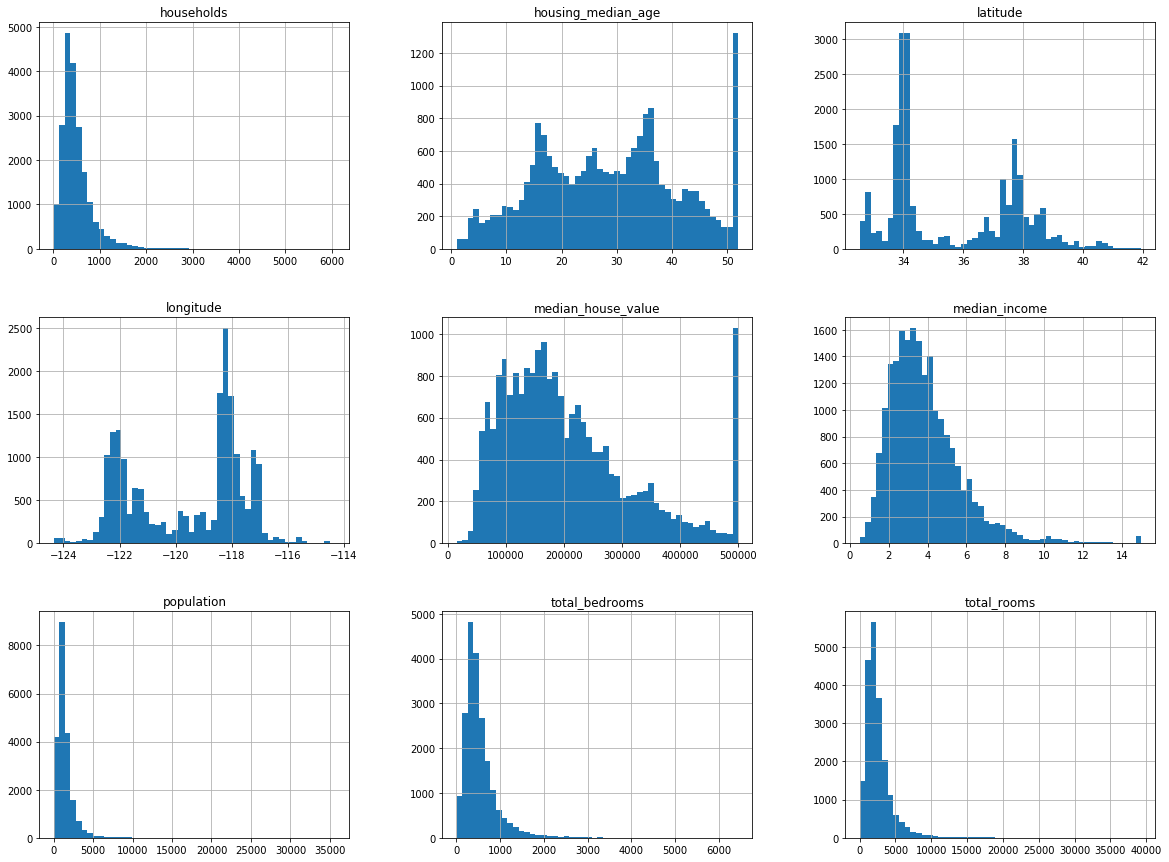

In [45]:
df.hist(bins=50, figsize=(20,15))

Thanks to this, we are able to spot few peculiarities

1. median house value looks like it had been capped at 500000. This is a disaster since this is our target data. We can fix this by removing the 5000 cap or ask for revision
2. the distribution of most features are left skewed

Note that our target, median_income is clustered mainly between 1 and 6. It is important to have a sufficient number of instances in our dataset for each stratum, or else the estimate of the stratum's importance may be biased. However, we will address this later using cross validation. For now it is perfectly okay to leave this be

In the scatter plot, the radius represents the district' population(option s) and the color represents the price(option c)

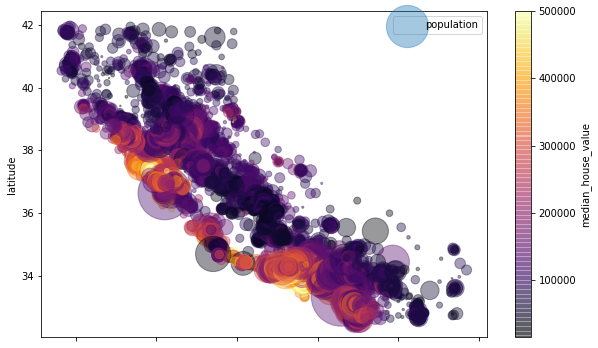

In [46]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
            s=df['population']/10,label='population',c="median_house_value",
            cmap=plt.get_cmap('inferno'),colorbar=True,figsize=(10,6)
            )
plt.legend()

Lets see how the features are correlated to each other using heatmap

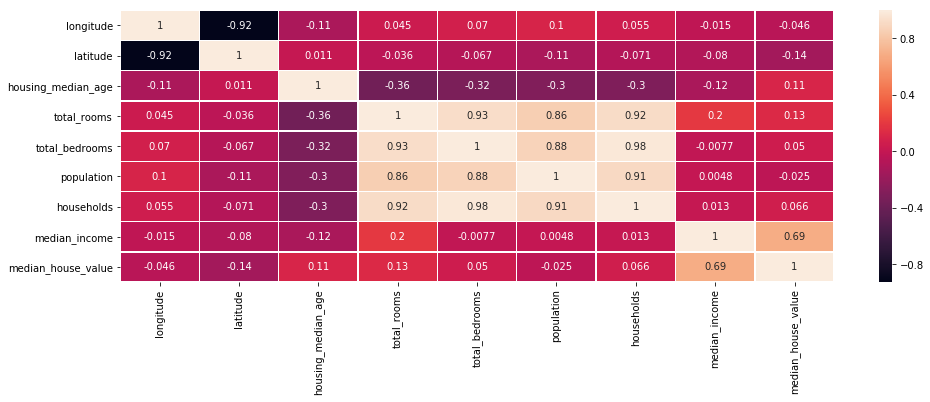

In [47]:
plt.figure(figsize=(16,5))
sns.heatmap(df.corr(),annot=True,linewidths=.5)

Feature engineering means that we're making new features based on existing features that can enhance our results/

In our case, total rooms and total bedrooms features doesnt really makes sense. It might work. But we can do it better. Intuitively, it would be more sensible to compute population per household, rooms per household, bedrooms per household, and also bedroom per total room. 

In [48]:
df['rooms_per_household']=df['total_rooms']/df['households']
df['bedrooms_per_total_rooms']=df['total_bedrooms']/df['total_rooms']
df['population_per_household']=df['population']/df['households']
df['bedrooms_per_household']=df['total_bedrooms']/df['households']

In [49]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
bedrooms_per_household     -0.046739
latitude                   -0.144160
bedrooms_per_total_rooms   -0.255880
Name: median_house_value, dtype: float64

It turns out that bedrooms per household and population per household is not a good feature to have. On the other hand, rooms per household and bedrooms per total rooms is totally cool features. Scikit-Learn provide a handy class to take care of missing values. Let's say we want to fill those NAs with its median. The great thing about imputer is that we can use it for multiple features

In [50]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [51]:
df_num = df.drop(["ocean_proximity","median_house_value"], axis=1)
arr_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(arr_num,columns=df_num.columns)

Most ML algorithms prefer to work with numbers, so lets change categorical variables to numbers. 

In [55]:
df_cat = pd.DataFrame(df['ocean_proximity'],columns=['ocean_proximity'])

from sklearn.preprocessing import LabelBinarizer


encoder = LabelBinarizer(sparse_output=True)
ocean_encoded = encoder.fit_transform(df['ocean_proximity'])

However, we can automate these tasks. The more we automate those, the faster we would achieve our goal